# Travel Minutes Difference

## 1. Mean Traveling Time Difference

In [1]:
#setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

np.random.seed(42)
%matplotlib inline

In [2]:
pd.options.display.max_columns = 999

In [3]:
#import mean daily trvel time data
mean0320 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0320_mean.csv")
mean0319 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0319_mean.csv")

In [4]:
#extract the census track number
mean0320["des_census"] = mean0320["Destination Display Name"].str[13:]
#change seconds to minutes
mean0320["mean_travel_min_20"] = mean0320["Mean Travel Time (Seconds)"] / 60

In [5]:
#extract the census track number
mean0319["des_census"] = mean0319["Destination Display Name"].str[13:]
#change seconds to minutes
mean0319["mean_travel_min_19"] = mean0319["Mean Travel Time (Seconds)"] / 60

In [6]:
#select out the needed columns
mean0320_sel = mean0320[["des_census", "mean_travel_min_20"]]
mean0319_sel = mean0319[["des_census", "mean_travel_min_19"]]

In [7]:
#merge two datasets
meandiff = pd.merge(mean0319_sel, mean0320_sel, how="outer")

In [8]:
meandiff["time_diff"] = meandiff["mean_travel_min_20"] - meandiff["mean_travel_min_19"]

### get census geometry from cenpy

In [9]:
import cenpy

In [10]:
# Initialize the API connection
# SELECT ACSDT5Y2018
acs = cenpy.remote.APIConnection("ACSDT5Y2018")

In [11]:
#explore US counties
counties = cenpy.explorer.fips_table("COUNTY")
counties.head()

,0,1,2,3,4
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [12]:
#Search for LA county
counties.loc[counties[3].str.contains("Los Angeles") ]

,0,1,2,3,4
204,CA,6,37,Los Angeles County,H1


We get fips code for California State: 6 <br>
And fips code for Los Angeles County: 37

In [13]:
la_county_code = "037"
ca_state_code = "06"

In [14]:
#connect
#Set the ACS2018 database as the desired GeoService
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [15]:
#ESRI census track layer
acs.mapservice.layers[10]

(ESRILayer) Census Block Groups

In [16]:
# Use SQL to return geometries only for Philadelphia County in PA
where_clause = f"STATE = {ca_state_code} AND COUNTY = {la_county_code}"

# Query for block groups
la_block_groups = acs.mapservice.layers[10].query(where=where_clause)

C:\Users\pc\miniconda3\envs\musa-550-fall-2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
#Only select out the census track and geometry
la_sel = la_block_groups[["TRACT", "geometry"]]

In [18]:
#brief view
la_sel.head()

,TRACT,geometry
0,541700,"POLYGON ((-13158992.626 4017650.518, -13158934..."
1,407400,"POLYGON ((-13131669.146 4035871.812, -13131464..."
2,407601,"POLYGON ((-13130126.369 4033798.978, -13130119..."
3,407502,"POLYGON ((-13129109.688 4033716.497, -13129102..."
4,407602,"POLYGON ((-13130031.970 4032349.333, -13130031..."


In [19]:
#dissolve polygons which have same "TRACT" number
la_poly = la_sel.dissolve(by="TRACT",as_index=False)

In [20]:
#crate a track list from meandiff
track_list = meandiff["des_census"]

In [21]:
#select only polygons within the list
la_geom_mean = la_poly.loc[la_poly["TRACT"].isin(track_list)]

In [22]:
#merge the geometry with meandiff
timediff = pd.merge(la_geom_mean, meandiff, left_on="TRACT", right_on="des_census", how="right")

### Plot

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

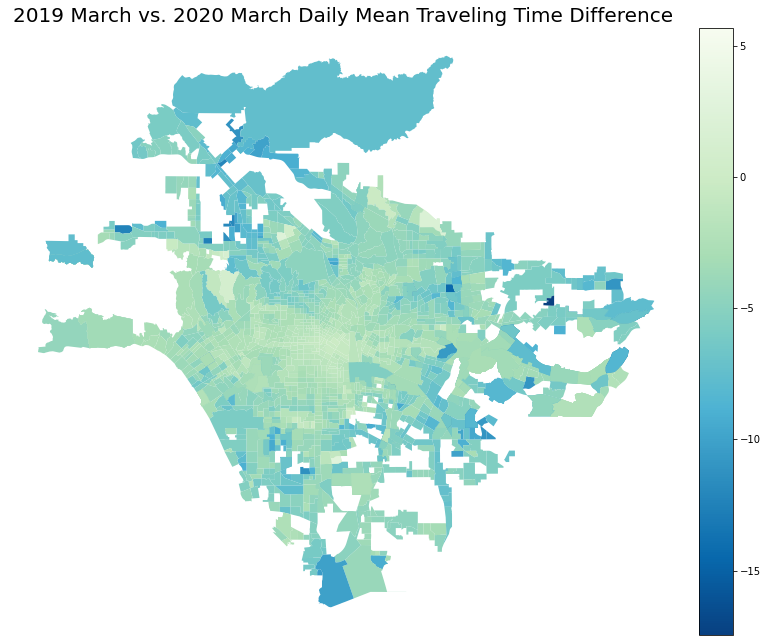

In [24]:
fig, ax = plt.subplots(figsize=(13,13))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")

# Plot the choropleth
mean = timediff.plot(ax=ax,
              cax=cax,
              column='time_diff',
              legend=True, 
              cmap="GnBu_r")


# Format
ax.set_title("2019 March vs. 2020 March Daily Mean Traveling Time Difference ", fontsize=20)
ax.set_axis_off()
ax.set_aspect("equal")

#save
plt.savefig("meandiff.png", dpi=600)

## 2. Traveling Time Difference at AM Rush

In [25]:
#loaddata
am0320 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0320_ampeak.csv")
am0319 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0319_ampeak.csv")

In [26]:
#extract census track number
am0319["des_census"] = am0319["Destination Display Name"].str[13:]
am0320["des_census"] = am0320["Destination Display Name"].str[13:]

In [27]:
#change seconds to minutes
am0319["am_travel_mean_19"] = am0319["Mean Travel Time (Seconds)"] / 60
am0320["am_travel_mean_20"] = am0320["Mean Travel Time (Seconds)"] / 60

In [28]:
am0319_sel = am0319[["des_census", "am_travel_mean_19"]]

In [29]:
am0320_sel = am0320[["des_census", "am_travel_mean_20"]]

In [30]:
#merge two datasets
amdiff = pd.merge(am0319_sel, am0320_sel, how="outer")

In [31]:
amdiff["time_diff"] = amdiff["am_travel_mean_20"] - amdiff["am_travel_mean_19"]

In [32]:
#brief view of table
amdiff.head()

,des_census,am_travel_mean_19,am_travel_mean_20,time_diff
0,480302,26.733333,21.833333,-4.900000
1,480303,26.050000,NaN,NaN
2,480304,23.516667,19.266667,-4.250000
3,480400,28.333333,19.816667,-8.516667
4,480802,23.766667,16.750000,-7.016667


The NaN are places where there are no recorded travel time in year 2019 or in year 2020. Those missing data will not be visualized later.

In [33]:
#crate a track list from amdiff
am_tracklist = amdiff["des_census"]

In [34]:
#select only polygons within the list
la_geom_am = la_poly.loc[la_poly["TRACT"].isin(track_list)]

In [35]:
#merge the geometry with meandiff
amdiff = pd.merge(la_geom_am, amdiff, left_on="TRACT", right_on="des_census", how="right")

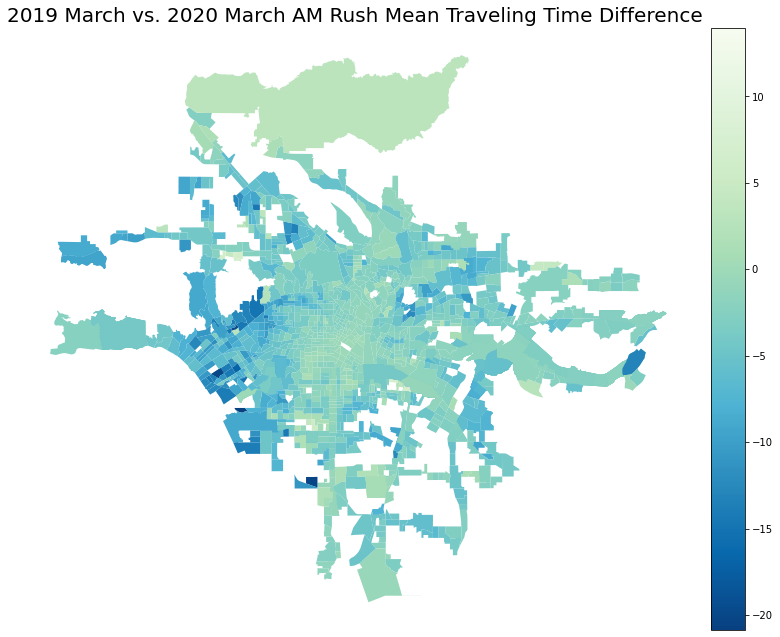

In [36]:
fig, ax = plt.subplots(figsize=(13,13))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")

# Plot the choropleth
amdiff.plot(ax=ax,
              cax=cax,
              column='time_diff',
              legend=True, 
              cmap="GnBu_r")

# Format
ax.set_title("2019 March vs. 2020 March AM Rush Mean Traveling Time Difference ", fontsize=20)
ax.set_axis_off()
ax.set_aspect("equal")

#save
plt.savefig("amdiff.png", dpi=600)

## 3. Traveling Time Difference at PM Rush

In [37]:
#load data
pm0319 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0319_pmpeak.csv")
pm0320 = pd.read_csv(r"C:\Users\pc\Downloads\Travel_Times_0320_pmpeak.csv")

In [38]:
#extract census track number
pm0319["des_census"] = pm0319["Destination Display Name"].str[13:]
pm0320["des_census"] = pm0320["Destination Display Name"].str[13:]

In [39]:
#change seconds to minutes
pm0319["pm_travel_mean_19"] = pm0319["Mean Travel Time (Seconds)"] / 60
pm0320["pm_travel_mean_20"] = pm0320["Mean Travel Time (Seconds)"] / 60

In [40]:
#select used columns
pm0319_sel = pm0319[["des_census", "pm_travel_mean_19"]]

In [41]:
#select used columns
pm0320_sel = pm0320[["des_census", "pm_travel_mean_20"]]

In [42]:
#merge two datasets
pmdiff = pd.merge(pm0319_sel, pm0320_sel, how="outer")

In [43]:
#calculate time diff
pmdiff["time_diff"] = pmdiff["pm_travel_mean_20"] - pmdiff["pm_travel_mean_19"]

In [44]:
#brief view of data
pmdiff.head()

,des_census,pm_travel_mean_19,pm_travel_mean_20,time_diff
0,480302,39.716667,27.666667,-12.050000
1,480303,33.216667,23.116667,-10.100000
2,480304,33.750000,24.100000,-9.650000
3,480400,37.433333,28.400000,-9.033333
4,480500,36.983333,29.900000,-7.083333


In [45]:
#crate a track list from pmdiff
pm_tracklist = pmdiff["des_census"]

In [46]:
#select only polygons within the list
la_geom_pm = la_poly.loc[la_poly["TRACT"].isin(pm_tracklist)]

In [47]:
#merge the geometry with meandiff
pmdiff = pd.merge(la_geom_am, pmdiff, left_on="TRACT", right_on="des_census", how="right")

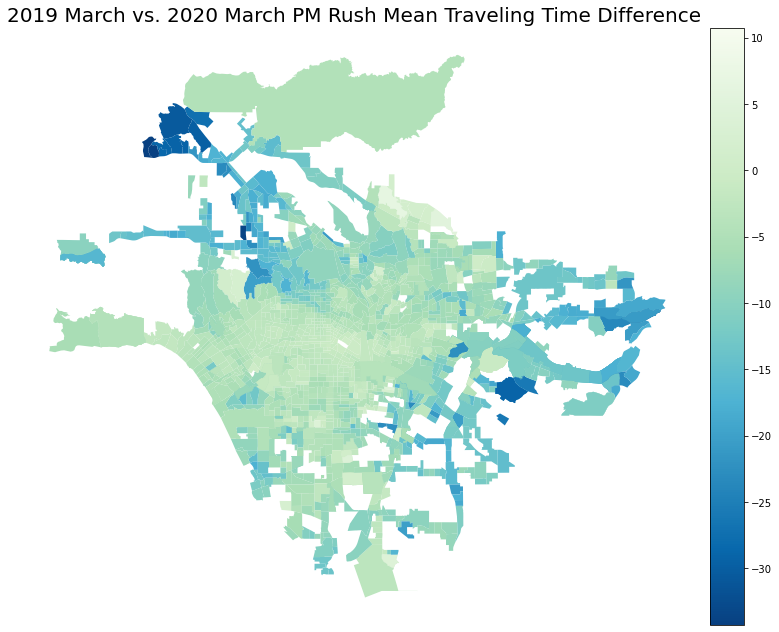

In [48]:
fig, ax = plt.subplots(figsize=(13,13))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")

# Plot the choropleth
pmdiff.plot(ax=ax,
              cax=cax,
              column='time_diff',
              legend=True, 
              cmap="GnBu_r")

# Format
ax.set_title("2019 March vs. 2020 March PM Rush Mean Traveling Time Difference ", fontsize=20)
ax.set_axis_off()
ax.set_aspect("equal")

#save
plt.savefig("pmdiff.png", dpi=600)